# Introduction

* The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:
    * The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
    * Computer vision methods can be used to determine age of a person from a photo
    * The task then is to build and evaluate a model for verifying people's age.

## Initialization

In [1]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import inspect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


## EDA

In [4]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [5]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

In [6]:
labels.shape

(7591, 2)

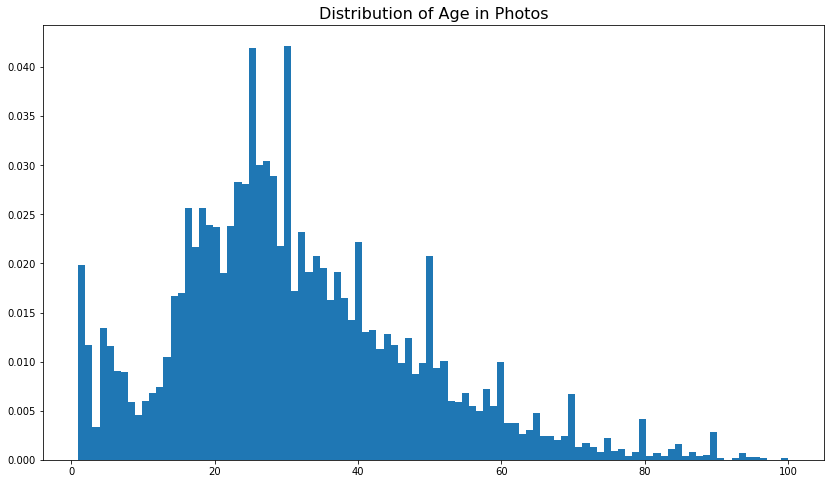

In [7]:
# plot age distribution
plt.figure(figsize=(14,8))
plt.hist(labels.real_age, bins=100, density=True,)
plt.title('Distribution of Age in Photos', fontsize=16)
plt.show() 

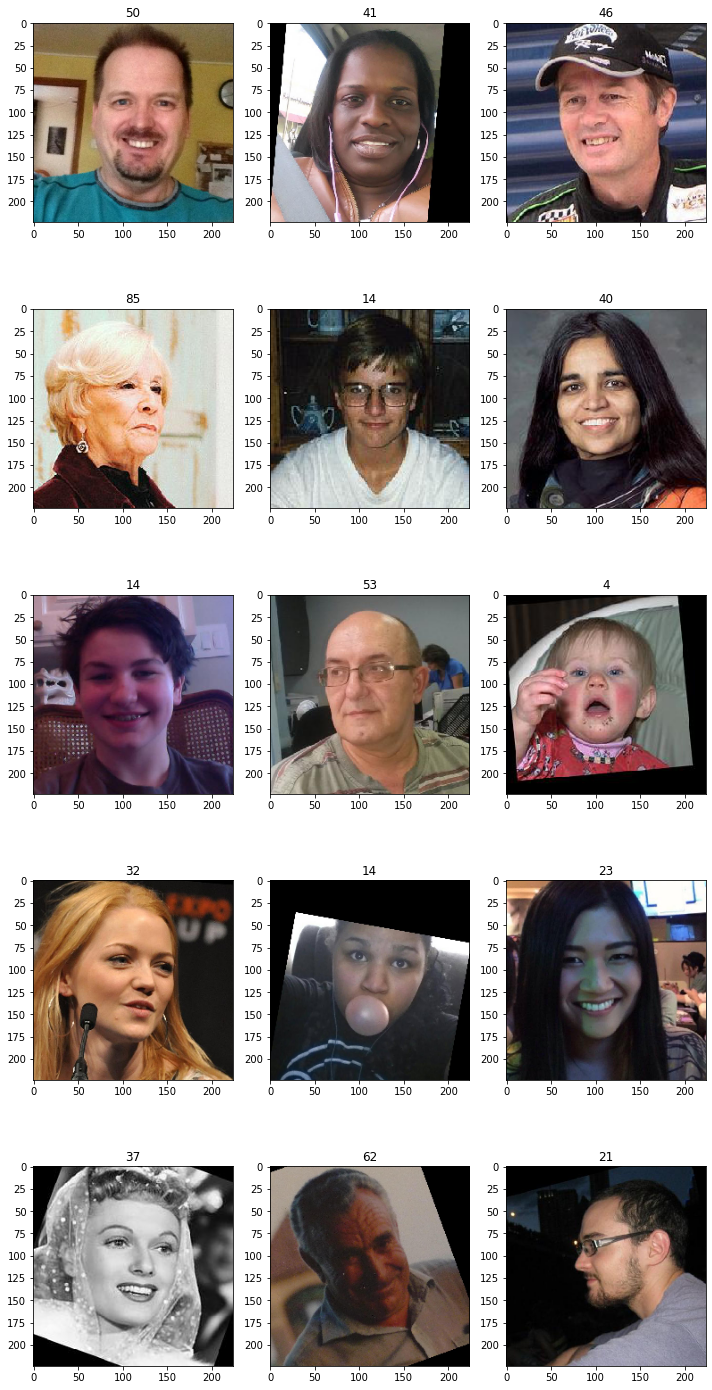

In [8]:
# display sample of photos
def show_batch(batch, predictions=None):
    fig = plt.figure(figsize=(10, 20))

    for i in range(15):
        fig.add_subplot(5, 3, i+1)
        plt.imshow(batch[0][i])
        title = batch[1][i]
        if predictions is not None:
            title = f'gt: {title}, pred: {round(predictions[i])}'
        plt.title(title)

    fig.tight_layout()

show_batch(next(train_gen_flow))

### Findings

* Most of the images contain photos of people with the age range between 15-45
* There are 7591 jpg files 



## Modelling

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
    return train_gen_flow


In [11]:
def load_test(path):
    labels= pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen_flow= test_datagen.flow_from_dataframe(dataframe=labels, directory='/datasets/faces/final_files/', x_col='file_name', y_col='real_age', subset='validation', target_size=(224,224), batch_size=32, class_mode='raw', seed=12345)
    
    return test_gen_flow

In [12]:
def create_model(input_shape):
    backbone=ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model=Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer=Adam(lr=.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    return model


## Prepare the Script to Run on the GPU Platform

In [14]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

* Train for 178 steps, validate for 60 steps

Epoch 1/20
2022-10-08 21:27:40.236642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-08 21:27:41.507723: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 59s - loss: 236.2256 - mae: 10.8702 - val_loss: 817.7901 - val_mae: 23.6929
Epoch 2/20
178/178 - 38s - loss: 58.3389 - mae: 5.8253 - val_loss: 805.5477 - val_mae: 23.4289
Epoch 3/20
178/178 - 38s - loss: 31.1202 - mae: 4.3203 - val_loss: 382.4281 - val_mae: 14.8699
Epoch 4/20
178/178 - 38s - loss: 20.9757 - mae: 3.5366 - val_loss: 169.8637 - val_mae: 10.4340
Epoch 5/20
178/178 - 38s - loss: 15.8152 - mae: 3.0630 - val_loss: 77.7217 - val_mae: 6.6991
Epoch 6/20
178/178 - 38s - loss: 12.6910 - mae: 2.7566 - val_loss: 69.8192 - val_mae: 6.3596
Epoch 7/20
178/178 - 37s - loss: 10.0262 - mae: 2.4743 - val_loss: 67.5580 - val_mae: 6.3790
Epoch 8/20
178/178 - 37s - loss: 8.6002 - mae: 2.2300 - val_loss: 78.8235 - val_mae: 7.0487
Epoch 9/20
178/178 - 37s - loss: 7.2431 - mae: 2.0522 - val_loss: 66.3156 - val_mae: 6.1516
Epoch 10/20
178/178 - 37s - loss: 7.3331 - mae: 2.0423 - val_loss: 75.4117 - val_mae: 6.7535
Epoch 11/20
178/178 - 37s - loss: 8.0083 - mae: 2.1229 - val_loss: 73.4586 - val_mae: 6.3969
Epoch 12/20
178/178 - 37s - loss: 7.2228 - mae: 2.0233 - val_loss: 63.9752 - val_mae: 5.9538
Epoch 13/20
178/178 - 37s - loss: 6.2398 - mae: 1.8773 - val_loss: 65.6078 - val_mae: 6.1281
Epoch 14/20
178/178 - 37s - loss: 5.8644 - mae: 1.8051 - val_loss: 64.8187 - val_mae: 6.2028
Epoch 15/20
178/178 - 38s - loss: 5.3193 - mae: 1.7328 - val_loss: 65.1410 - val_mae: 6.1317
Epoch 16/20
178/178 - 38s - loss: 5.0657 - mae: 1.7060 - val_loss: 77.3151 - val_mae: 6.5215
Epoch 17/20
178/178 - 37s - loss: 4.7792 - mae: 1.6529 - val_loss: 70.3029 - val_mae: 6.5352
Epoch 18/20
178/178 - 37s - loss: 4.4952 - mae: 1.5994 - val_loss: 75.2976 - val_mae: 6.4442
Epoch 19/20
178/178 - 37s - loss: 4.6062 - mae: 1.6322 - val_loss: 62.2095 - val_mae: 5.9446
Epoch 20/20
178/178 - 37s - loss: 4.6993 - mae: 1.6429 - val_loss: 65.3580 - val_mae: 6.1480
60/60 - 9s - loss: 65.3580 - mae: 6.1480

***Test MAE: 6.1480

## Conclusions

* The objective of this project was to build and evaluate a model that would accurately predict a person's age based on their photo. Given that the overall MAW was 2.4905, which is well below the desired threshold of 8, we conclude that the model works considerably well at predicting a person's age based on their photo/image. In this model, exactly 20 epochs we run with a batch size of 32. 
* This model utilized the Adam optimizer and ResNet50 architechture and as well as RELu activation. 
* Other uses of a model such as this could be applied to other situations that require determination of age prior to approval. * * For instance, at movie theatatures, instead of asking for identification, computer vision models like this can be used to determine whether or not a person would be allowed to watch a ra